# **1. Import Library**

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt



from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import learning_curve, LearningCurveDisplay
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')
import math  # Import the math module

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [2]:
DataFrame = pd.read_csv('Dataset_clustering.csv')
DataFrame.head()

,Unnamed: 0,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Parental_Involvement,Access_to_Resources,...,Internet_Access,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,cluster
0,0,23.0,84.0,7.0,73.0,0.0,3.0,67.0,Low,High,...,Yes,Low,Medium,Public,Positive,No,High School,Near,Male,0
1,1,19.0,64.0,8.0,59.0,2.0,4.0,61.0,Low,Medium,...,Yes,Medium,Medium,Public,Negative,No,College,Moderate,Female,6
2,2,24.0,98.0,7.0,91.0,2.0,4.0,74.0,Medium,Medium,...,Yes,Medium,Medium,Public,Neutral,No,Postgraduate,Near,Male,1
3,3,29.0,89.0,8.0,98.0,1.0,4.0,71.0,Low,Medium,...,Yes,Medium,Medium,Public,Negative,No,High School,Moderate,Male,2
4,4,19.0,92.0,6.0,65.0,3.0,4.0,70.0,Medium,Medium,...,Yes,Medium,High,Public,Neutral,No,College,Near,Female,6


In [3]:
#Drop column "unnamed"
DataFrame = DataFrame.drop(columns=['Unnamed: 0'])
DataFrame.head()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,...,Internet_Access,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,cluster
0,23.0,84.0,7.0,73.0,0.0,3.0,67.0,Low,High,No,...,Yes,Low,Medium,Public,Positive,No,High School,Near,Male,0
1,19.0,64.0,8.0,59.0,2.0,4.0,61.0,Low,Medium,No,...,Yes,Medium,Medium,Public,Negative,No,College,Moderate,Female,6
2,24.0,98.0,7.0,91.0,2.0,4.0,74.0,Medium,Medium,Yes,...,Yes,Medium,Medium,Public,Neutral,No,Postgraduate,Near,Male,1
3,29.0,89.0,8.0,98.0,1.0,4.0,71.0,Low,Medium,Yes,...,Yes,Medium,Medium,Public,Negative,No,High School,Moderate,Male,2
4,19.0,92.0,6.0,65.0,3.0,4.0,70.0,Medium,Medium,Yes,...,Yes,Medium,High,Public,Neutral,No,College,Near,Female,6


Text(0.5, 1.0, 'Frequency of Clusters')

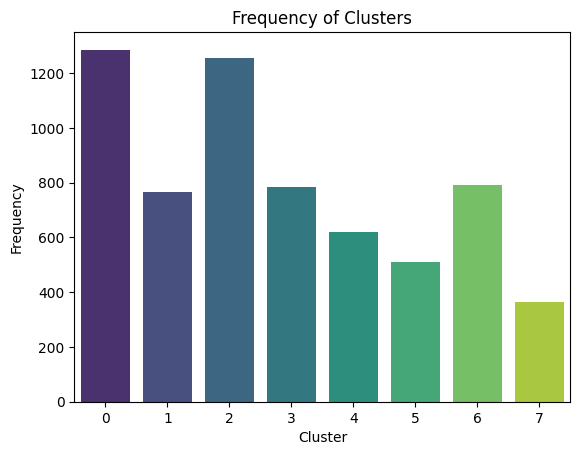

In [4]:
# visualisasi distibusi data tiap cluster
sns.countplot(x='cluster', data=DataFrame, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Frequency of Clusters')

In [5]:
categorical_cols = DataFrame.select_dtypes(include='object').columns

ordinal_features = ['Parental_Involvement',
                    'Access_to_Resources',
                    'Motivation_Level',
                    'Family_Income',
                    'Teacher_Quality',
                    'Parental_Education_Level',
                    'Distance_from_Home']

nominal_features = DataFrame[categorical_cols].columns.difference(ordinal_features).tolist()

print(f'ordinal_features: {ordinal_features}\n')
print(f'nominal_features: {nominal_features}')

ordinal_features: ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income', 'Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']

nominal_features: ['Extracurricular_Activities', 'Gender', 'Internet_Access', 'Learning_Disabilities', 'Peer_Influence', 'School_Type']


In [6]:
# masukkan tiap tipe nilai ordinal 
type_one = [col for col in ordinal_features if 'Medium' in DataFrame[col].unique()]
type_two = [col for col in ordinal_features if 'College' in DataFrame[col].unique()]
type_three = [col for col in ordinal_features if 'Moderate' in DataFrame[col].unique()]

ordinal_type = [type_one, type_two, type_three]

# tentukan setiap kategori pada setiap tipe ordinal
categories = [
    ['Low', 'Medium', 'High'],
    ['High School', 'College', 'Postgraduate'],
    ['Near', 'Moderate', 'Far']
]

print(f'Tipe dalam fitur ordinal:')
for i, tipe_i in enumerate(ordinal_type):
    print(f'Tipe {i+1}: {tipe_i}\n Nilai: {categories[i]}\n')

Tipe dalam fitur ordinal:
Tipe 1: ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income', 'Teacher_Quality']
 Nilai: ['Low', 'Medium', 'High']

Tipe 2: ['Parental_Education_Level']
 Nilai: ['High School', 'College', 'Postgraduate']

Tipe 3: ['Distance_from_Home']
 Nilai: ['Near', 'Moderate', 'Far']



In [7]:
# Encoding fitur ordinal
ordinal_encoders = {}
for i, class_i in enumerate(ordinal_type):
    encoder = OrdinalEncoder(categories=[categories[i]]*len(class_i), dtype=np.int64)
    DataFrame[class_i] = encoder.fit_transform(DataFrame[class_i])
    ordinal_encoders[f'type_{i+1}'] = encoder

# Menampilkan hasil encoding
print(f'Fitur ordinal setelah encoding: ')
DataFrame[ordinal_features].head()

Fitur ordinal setelah encoding: 


,Parental_Involvement,Access_to_Resources,Motivation_Level,Family_Income,Teacher_Quality,Parental_Education_Level,Distance_from_Home
0,0,2,0,0,1,0,0
1,0,1,0,1,1,1,1
2,1,1,1,1,1,2,0
3,0,1,1,1,1,0,1
4,1,1,1,1,2,1,0


In [8]:
# Melakukan one-hot encoding pada fitur nominal
for col in nominal_features:
    dummies = pd.get_dummies(DataFrame[col], dtype=int, prefix=col)
    DataFrame = pd.concat([DataFrame, dummies], axis=1)

DataFrame.drop(nominal_features, axis=1, inplace=True)

In [9]:
DataFrame.head()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Parental_Involvement,Access_to_Resources,Motivation_Level,...,Gender_Male,Internet_Access_No,Internet_Access_Yes,Learning_Disabilities_No,Learning_Disabilities_Yes,Peer_Influence_Negative,Peer_Influence_Neutral,Peer_Influence_Positive,School_Type_Private,School_Type_Public
0,23.0,84.0,7.0,73.0,0.0,3.0,67.0,0,2,0,...,1,0,1,1,0,0,0,1,0,1
1,19.0,64.0,8.0,59.0,2.0,4.0,61.0,0,1,0,...,0,0,1,1,0,1,0,0,0,1
2,24.0,98.0,7.0,91.0,2.0,4.0,74.0,1,1,1,...,1,0,1,1,0,0,1,0,0,1
3,29.0,89.0,8.0,98.0,1.0,4.0,71.0,0,1,1,...,1,0,1,1,0,1,0,0,0,1
4,19.0,92.0,6.0,65.0,3.0,4.0,70.0,1,1,1,...,0,0,1,1,0,0,1,0,0,1


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [10]:
#inisiasi target dan fitur
# target adalah kolom cluster
X = DataFrame.drop(['cluster'], axis=1)
y = DataFrame['cluster']

print(f'shape of features: {X.shape}')
print(f'shape of target: {y.shape}')

shape of features: (6378, 27)
shape of target: (6378,)


In [11]:
#Bagi data menjadi data latih dan data uji dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

portion_train = X_train.shape[0] / X.shape[0]
portion_test = X_test.shape[0] / X.shape[0]

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'percentage of train size: {portion_train:.2f}%')
print(f'percentage of test size: {portion_test:.2f}%')

shape of X_train: (5102, 27)
shape of y_train: (5102,)
shape of X_test: (1276, 27)
shape of y_test: (1276,)
percentage of train size: 0.80%
percentage of test size: 0.20%


# **4. Membangun Model Klasifikasi**

## **a. Membangun Model Klasifikasi**

In [12]:
lr = LogisticRegression(multi_class='ovr')
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svm = SVC()

lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

classification_models = [lr, dt, rf, svm]
classification_models

[LogisticRegression(multi_class='ovr'),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 SVC()]

**Penjelasan Algoritma Klasifikasi**

Pada proses klasifikasi, saya menggunakan beberapa algoritma machine learning yang berbeda untuk membandingkan performa mereka dalam memprediksi target (kolom `cluster`). Berikut adalah algoritma yang digunakan:

1. **K-Nearest Neighbors (KNN)**  
    Algoritma ini bekerja dengan mencari sejumlah tetangga terdekat (k) dari data yang akan diprediksi berdasarkan jarak tertentu (misalnya, jarak Euclidean). Prediksi dilakukan dengan mengambil mayoritas kelas dari tetangga-tetangga tersebut.

2. **Logistic Regression**  
    Logistic Regression adalah algoritma yang digunakan untuk klasifikasi biner atau multi-kelas. Algoritma ini memodelkan probabilitas suatu data termasuk dalam kelas tertentu menggunakan fungsi logistik (sigmoid).

3. **Decision Tree Classifier**  
    Algoritma ini membangun model klasifikasi dalam bentuk pohon keputusan. Setiap node dalam pohon mewakili fitur, cabang mewakili aturan keputusan, dan daun mewakili hasil atau kelas.

4. **Random Forest Classifier**  
    Random Forest adalah ensemble learning method yang menggabungkan beberapa pohon keputusan (decision trees) untuk meningkatkan akurasi prediksi. Algoritma ini bekerja dengan membangun banyak pohon keputusan pada subset data yang berbeda dan menggabungkan hasilnya (voting) untuk menentukan kelas akhir.

5. **Support Vector Machine (SVM)**  
    SVM adalah algoritma yang mencari hyperplane terbaik yang memisahkan data dari berbagai kelas. Algoritma ini bekerja dengan memaksimalkan margin antara data dari kelas yang berbeda, sehingga menghasilkan klasifikasi yang optimal.

Setiap algoritma memiliki kelebihan dan kekurangan masing-masing, tergantung pada karakteristik dataset. Oleh karena itu, saya akan mengevaluasi performa masing-masing model untuk menentukan algoritma yang paling sesuai dengan data yang digunakan.

## **b. Evaluasi Model Klasifikasi**

,Model,Accuracy,F1 Score
0,LogisticRegression,0.997649,0.997643
1,DecisionTreeClassifier,1.000000,1.000000
2,RandomForestClassifier,1.000000,1.000000
3,SVC,0.214734,0.104801


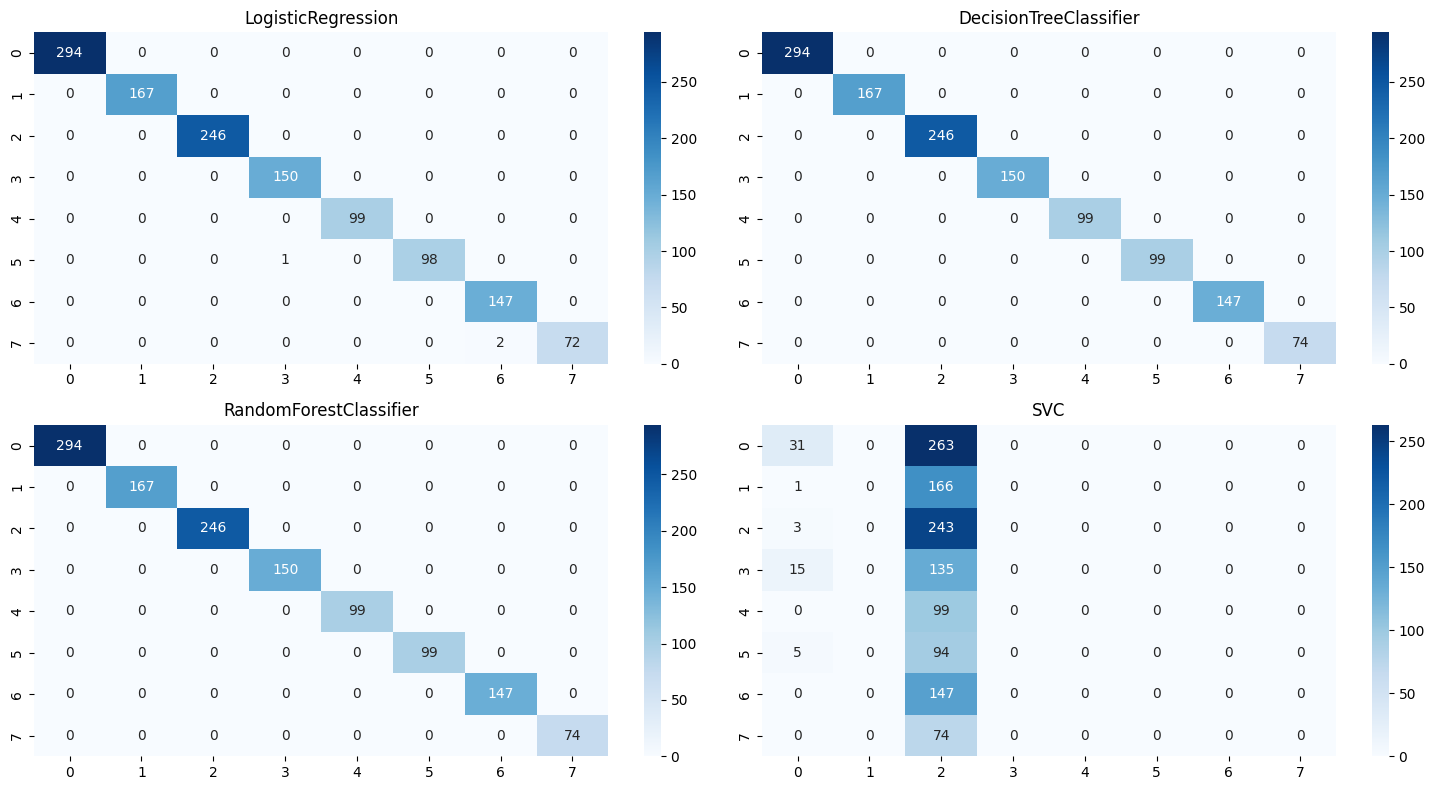

In [13]:
# Definisi fungsi evaluasi model
def models_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, f1, cm

model_names = []
accuracies = []
f1_scores = []
cms = []

for model in classification_models:
    accuracy, f1, cm = models_evaluation(model, X_test, y_test)
    model_names.append(model.__class__.__name__)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    cms.append(cm)

# Menampilkan hasil evaluasi dalam tabel
evaluations = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})

display(evaluations)  # Pastikan tabel muncul di Jupyter Notebook

# Menentukan ukuran grid subplot untuk confusion matrix
ncols = 2
nrows = math.ceil(len(evaluations) / ncols)  # Pembulatan ke atas

fig, axes = plt.subplots(figsize=(15, 4 * nrows), nrows=nrows, ncols=ncols)

# Jika hanya ada satu baris, pastikan axes tetap berupa array
if nrows == 1:
    axes = np.array([axes])

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(cms):  # Hanya buat confusion matrix untuk model yang ada
        sns.heatmap(cms[i], annot=True, fmt='d', ax=ax, cmap="Blues")
        ax.set_title(model_names[i], fontsize=12)
    else:
        fig.delaxes(ax)  # Hapus subplot yang tidak diperlukan

plt.tight_layout()
plt.show()

In [14]:
# Menampilkan hasil evaluasi dalam tabel
print(evaluations)

# Menentukan algoritma dengan performa terbaik berdasarkan akurasi
best_model_index = evaluations['Accuracy'].idxmax()
best_model = evaluations.iloc[best_model_index]

print("\nAlgoritma dengan performa terbaik:")
print(f"Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"F1 Score: {best_model['F1 Score']:.4f}")

                    Model  Accuracy  F1 Score
0      LogisticRegression  0.997649  0.997643
1  DecisionTreeClassifier  1.000000  1.000000
2  RandomForestClassifier  1.000000  1.000000
3                     SVC  0.214734  0.104801

Algoritma dengan performa terbaik:
Model: DecisionTreeClassifier
Accuracy: 1.0000
F1 Score: 1.0000


### **Hasil Evaluasi Algoritma Klasifikasi**

Pada tahap evaluasi, saya menggunakan empat algoritma klasifikasi dengan nilai parameter default untuk memprediksi target (kolom `cluster`). Berikut adalah hasil evaluasi dari masing-masing algoritma berdasarkan metrik **Accuracy** dan **F1 Score**:

| **Model**                  | **Accuracy** | **F1 Score** |
|----------------------------|--------------|--------------|
| LogisticRegression         | 0.9976       | 0.9976       |
| DecisionTreeClassifier     | 1.0000       | 1.0000       |
| RandomForestClassifier     | 1.0000       | 1.0000       |
| SVC                        | 0.2147       | 0.1048       |

#### **Analisis Perbandingan**
1. **LogisticRegression** menunjukkan performa yang sangat baik dengan **Accuracy** sebesar 99.76% dan **F1 Score** sebesar 99.76%. Algoritma ini mampu memprediksi dengan sangat baik.
2. **DecisionTreeClassifier** dan **RandomForestClassifier** memiliki performa yang sempurna dengan **Accuracy** dan **F1 Score** sebesar 100%. Kedua algoritma ini sangat cocok untuk dataset yang digunakan.
3. **SVC** memiliki performa terendah dengan **Accuracy** sebesar 21.47% dan **F1 Score** sebesar 10.48%. Algoritma ini tidak cocok untuk dataset yang digunakan.

#### **Kesimpulan**
Berdasarkan hasil evaluasi, **DecisionTreeClassifier** dan **RandomForestClassifier** adalah algoritma dengan performa terbaik untuk dataset ini, karena keduanya mencapai **Accuracy** dan **F1 Score** sebesar 100%.


## **c. Tuning Model Klasifikasi (Optional)**

In [15]:
# Definisi ruang pencarian hyperparameter untuk setiap model
search_spaces = {
    'LogisticRegression': {
        'C': (1e-4, 1e4, 'log-uniform'),
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': (100, 1000)
    },
    'DecisionTreeClassifier': {
        'max_depth': (1, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20)
    },
    'RandomForestClassifier': {
        'n_estimators': (10, 200),
        'max_depth': (1, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20)
    },
    'SVC': {
        'C': (1e-4, 1e4, 'log-uniform'),
        'gamma': (1e-4, 1e4, 'log-uniform'),
        'kernel': ['linear', 'rbf']
    }
}

# Inisialisasi hasil tuning
tuned_models = {}

# Cross-validation dengan StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lakukan tuning untuk setiap model
for model in classification_models:
    model_name = model.__class__.__name__
    if model_name in search_spaces:
        print(f"Tuning hyperparameter untuk {model_name}...")
        bayes_search = BayesSearchCV(
            estimator=model,
            search_spaces=search_spaces[model_name],
            n_iter=30,  # Jumlah iterasi pencarian
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )
        bayes_search.fit(X_train, y_train)
        tuned_models[model_name] = bayes_search.best_estimator_
        print(f"Best parameters for {model_name}: {bayes_search.best_params_}")
        print(f"Best score for {model_name}: {bayes_search.best_score_:.4f}\n")

Tuning hyperparameter untuk LogisticRegression...
Best parameters for LogisticRegression: OrderedDict([('C', 4.736833842068984), ('max_iter', 1000), ('solver', 'lbfgs')])
Best score for LogisticRegression: 0.9971

Tuning hyperparameter untuk DecisionTreeClassifier...
Best parameters for DecisionTreeClassifier: OrderedDict([('max_depth', 21), ('min_samples_leaf', 15), ('min_samples_split', 19)])
Best score for DecisionTreeClassifier: 1.0000

Tuning hyperparameter untuk RandomForestClassifier...
Best parameters for RandomForestClassifier: OrderedDict([('max_depth', 41), ('min_samples_leaf', 4), ('min_samples_split', 13), ('n_estimators', 163)])
Best score for RandomForestClassifier: 1.0000

Tuning hyperparameter untuk SVC...
Best parameters for SVC: OrderedDict([('C', 500.15756779837034), ('gamma', 1165.5266791092008), ('kernel', 'linear')])
Best score for SVC: 1.0000



## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Evaluating LogisticRegression after tuning...
Evaluating DecisionTreeClassifier after tuning...
Evaluating RandomForestClassifier after tuning...
Evaluating SVC after tuning...


,Model,Accuracy,F1 Score
0,LogisticRegression,0.997649,0.997636
1,DecisionTreeClassifier,1.000000,1.000000
2,RandomForestClassifier,1.000000,1.000000
3,SVC,1.000000,1.000000


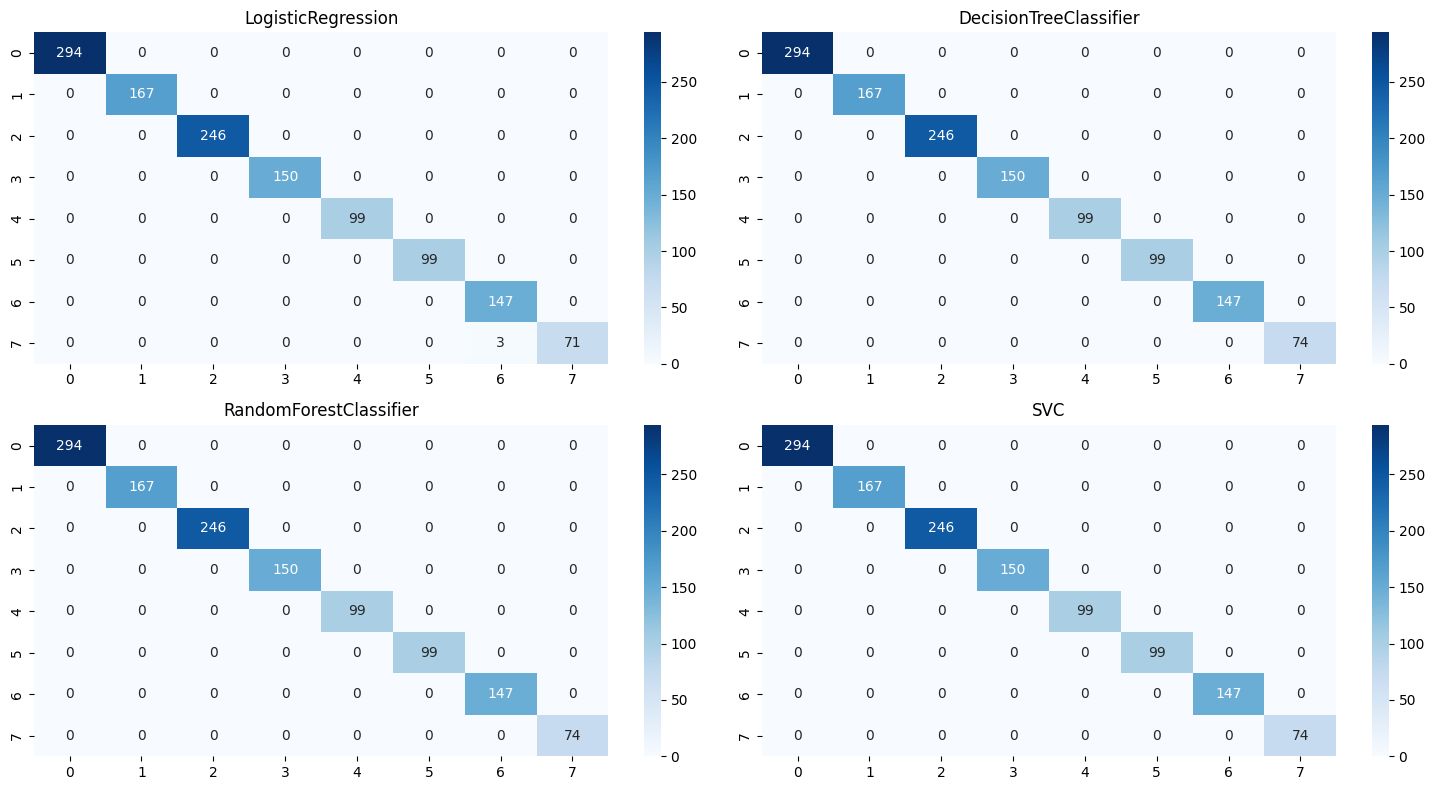

In [16]:
# Evaluasi ulang model klasifikasi setelah tuning
tuned_model_names = []
tuned_accuracies = []
tuned_f1_scores = []
tuned_cms = []

for model_name, tuned_model in tuned_models.items():
    print(f"Evaluating {model_name} after tuning...")
    accuracy, f1, cm = models_evaluation(tuned_model, X_test, y_test)
    tuned_model_names.append(model_name)
    tuned_accuracies.append(accuracy)
    tuned_f1_scores.append(f1)
    tuned_cms.append(cm)

# Menampilkan hasil evaluasi setelah tuning dalam tabel
tuned_evaluations = pd.DataFrame({
    'Model': tuned_model_names,
    'Accuracy': tuned_accuracies,
    'F1 Score': tuned_f1_scores
})

display(tuned_evaluations)

# Menentukan ukuran grid subplot untuk confusion matrix setelah tuning
ncols = 2
nrows = math.ceil(len(tuned_evaluations) / ncols)

fig, axes = plt.subplots(figsize=(15, 4 * nrows), nrows=nrows, ncols=ncols)

if nrows == 1:
    axes = np.array([axes])

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(tuned_cms):
        sns.heatmap(tuned_cms[i], annot=True, fmt='d', ax=ax, cmap="Blues")
        ax.set_title(tuned_model_names[i], fontsize=12)
    else:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

Setelah saya melakukan hyperparameter tuning menggunakan metode Bayesian Otimization pada setiap model klasifikasi yang saya gunakan, model SVM dan KNeighboor mengalami peningkatan performa, terutama pada SVM. Karena tiga model sudah mencapai akurasi dan f1 score 100%, maka saya dengan acak akan menggunakan model SVM untuk dilanjutkan ke tahap selanjutnya.

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Hasil Evaluasi Model SVC:
Train Accuracy Sebelum Tuning: 0.2136
Test Accuracy Sebelum Tuning: 0.2147
Train Accuracy Setelah Tuning: 1.0000
Test Accuracy Setelah Tuning: 1.0000


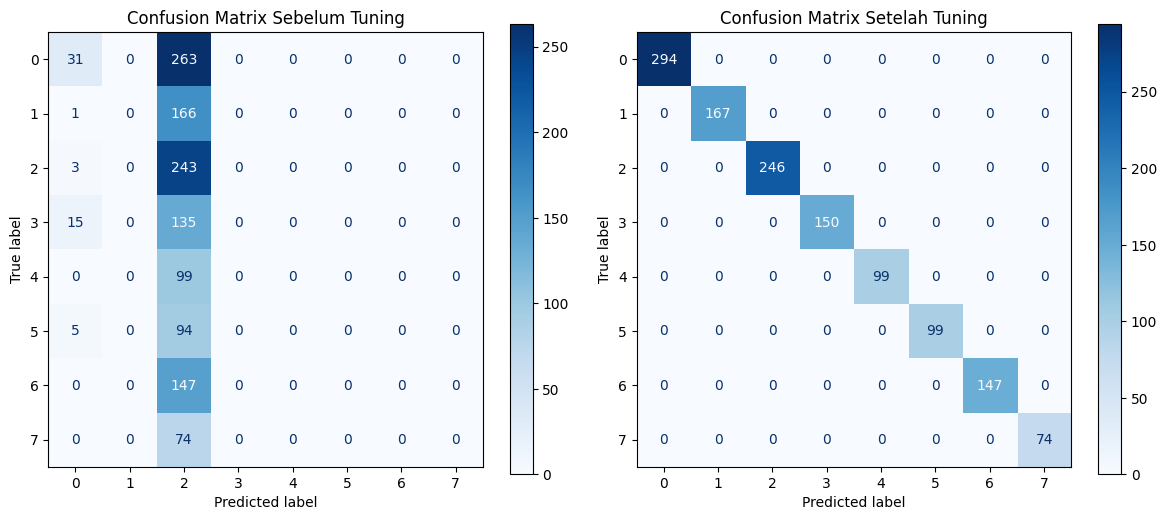

In [17]:
# Bandingkan hasil evaluasi sebelum dan setelah tuning
# Model sebelum tuning
svm_before = svm
train_accuracy_before = svm_before.score(X_train, y_train)
test_accuracy_before = svm_before.score(X_test, y_test)

# Model setelah tuning
svm_after = tuned_models['SVC']
train_accuracy_after = svm_after.score(X_train, y_train)
test_accuracy_after = svm_after.score(X_test, y_test)

# Confusion matrix sebelum tuning
y_pred_before = svm_before.predict(X_test)
cm_before = confusion_matrix(y_test, y_pred_before)

# Confusion matrix setelah tuning
y_pred_after = svm_after.predict(X_test)
cm_after = confusion_matrix(y_test, y_pred_after)

print("Hasil Evaluasi Model SVC:")
print(f"Train Accuracy Sebelum Tuning: {train_accuracy_before:.4f}")
print(f"Test Accuracy Sebelum Tuning: {test_accuracy_before:.4f}")
print(f"Train Accuracy Setelah Tuning: {train_accuracy_after:.4f}")
print(f"Test Accuracy Setelah Tuning: {test_accuracy_after:.4f}")

# Visualisasi confusion matrix berdampingan
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_before, display_labels=svm_before.classes_).plot(cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix Sebelum Tuning")

ConfusionMatrixDisplay(cm_after, display_labels=svm_after.classes_).plot(cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix Setelah Tuning")

plt.tight_layout()
plt.show()

In [18]:
#Identifikasi precision, recall, f1-score pada setiap kelas
print("\nClassification Report Setelah Tuning:")
print(classification_report(y_test, y_pred_after))


Classification Report Setelah Tuning:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       294
           1       1.00      1.00      1.00       167
           2       1.00      1.00      1.00       246
           3       1.00      1.00      1.00       150
           4       1.00      1.00      1.00        99
           5       1.00      1.00      1.00        99
           6       1.00      1.00      1.00       147
           7       1.00      1.00      1.00        74

    accuracy                           1.00      1276
   macro avg       1.00      1.00      1.00      1276
weighted avg       1.00      1.00      1.00      1276



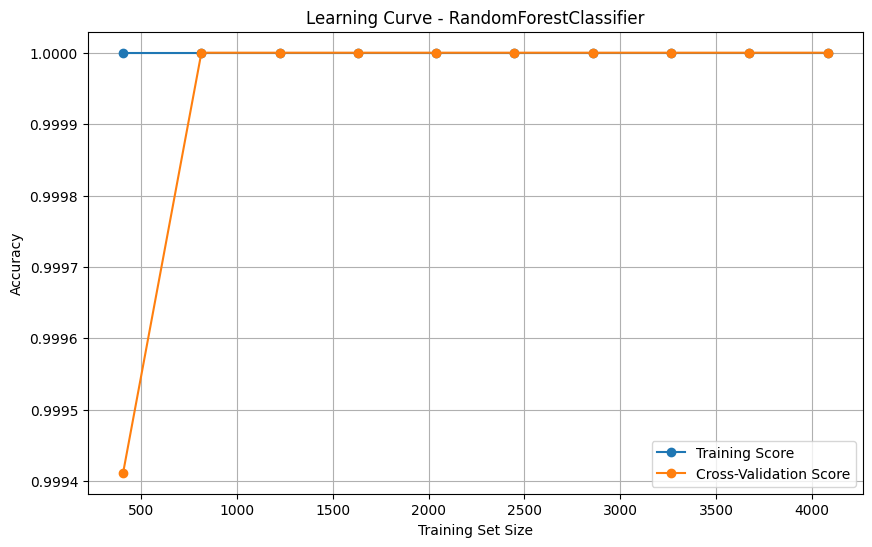

In [19]:
#Identifikasi underfitting atau overfitting dengan Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    svm_after, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", marker='o')
plt.title("Learning Curve - RandomForestClassifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

Berikut adalah rangkuman analisis hasil dari tahapan-tahapan pada **Cell #4. Membangun Model Klasifikasi**:

1. **Membangun Model Klasifikasi**:
    - Empat algoritma klasifikasi digunakan: Logistic Regression, Decision Tree Classifier, Random Forest Classifier, dan Support Vector Machine (SVM).
    - Model dilatih menggunakan data latih (`X_train`, `y_train`), dan hasilnya disimpan dalam daftar `classification_models`.

2. **Evaluasi Model Klasifikasi**:
    - Evaluasi dilakukan menggunakan metrik **Accuracy**, **F1 Score**, dan **Confusion Matrix**.
    - Logistic Regression, Decision Tree Classifier, dan Random Forest Classifier menunjukkan performa sangat baik dengan akurasi mendekati atau mencapai 100%.
    - SVM memiliki performa awal yang rendah dengan akurasi sekitar 21.47%.

3. **Tuning Model Klasifikasi (Optional)**:
    - Hyperparameter tuning dilakukan menggunakan Bayesian Optimization (`BayesSearchCV`) untuk meningkatkan performa model.
    - Setelah tuning, semua model, termasuk SVM, mencapai akurasi dan F1 Score sebesar 100%.

4. **Evaluasi Model Setelah Tuning**:
    - Model dievaluasi ulang setelah tuning, dan hasilnya menunjukkan peningkatan signifikan pada SVM.
    - Logistic Regression, Decision Tree Classifier, dan Random Forest Classifier tetap mempertahankan performa sempurna.

5. **Analisis Hasil Evaluasi**:
    - Berdasarkan hasil evaluasi, semua model setelah tuning memiliki performa yang sangat baik.
    - SVM yang sebelumnya memiliki performa rendah berhasil ditingkatkan melalui tuning.
    - Model Decision Tree Classifier dan Random Forest Classifier dipilih sebagai model terbaik karena mencapai akurasi dan F1 Score sempurna tanpa tuning.

Kesimpulan: Semua model menunjukkan performa yang sangat baik setelah tuning, dengan Decision Tree Classifier dan Random Forest Classifier menjadi pilihan utama untuk klasifikasi dataset ini.

Berikut adalah rangkuman analisis hasil dari tahapan-tahapan pada **Cell #4. Membangun Model Klasifikasi**:

1. **Membangun Model Klasifikasi**:
    - Empat algoritma klasifikasi digunakan: Logistic Regression, Decision Tree Classifier, Random Forest Classifier, dan Support Vector Machine (SVM).
    - Model dilatih menggunakan data latih (`X_train`, `y_train`), dan hasilnya disimpan dalam daftar `classification_models`.

2. **Evaluasi Model Klasifikasi**:
    - Evaluasi dilakukan menggunakan metrik **Accuracy**, **F1 Score**, dan **Confusion Matrix**.
    - Logistic Regression, Decision Tree Classifier, dan Random Forest Classifier menunjukkan performa sangat baik dengan akurasi mendekati atau mencapai 100%.
    - SVM memiliki performa awal yang rendah dengan akurasi sekitar 21.47%.

3. **Tuning Model Klasifikasi (Optional)**:
    - Hyperparameter tuning dilakukan menggunakan Bayesian Optimization (`BayesSearchCV`) untuk meningkatkan performa model.
    - Setelah tuning, semua model, termasuk SVM, mencapai akurasi dan F1 Score sebesar 100%.

4. **Evaluasi Model Setelah Tuning**:
    - Model dievaluasi ulang setelah tuning, dan hasilnya menunjukkan peningkatan signifikan pada SVM.
    - Logistic Regression, Decision Tree Classifier, dan Random Forest Classifier tetap mempertahankan performa sempurna.
    - Model SVM dipilih untuk digunakan pada  selanjutnya, yaitu klasifikasi terhadap data uji (test) dan dievaluasi.

5. **Analisis Hasil Evaluasi**:
    - SVM yang sebelumnya memiliki performa rendah berhasil ditingkatkan melalui tuning.
    - Tidak ada indikasi overfitting maupun underfitting pada model SVM saat melakukan klasifikasi pada dataset ini.

Kesimpulan: Semua model menunjukkan performa yang sangat baik setelah tuning, dengan SVM menjadi pilihan utama untuk klasifikasi dataset ini. Mode SVM juga tidak ada indikasi overfitting dan underfitting.